In [1]:
import numpy as np
import data_utils
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as T
import cv2

# will we be using GPUs?
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('Use GPU')
else:
    device = torch.device('cpu')
    print('Use CPU')
    
# float values used
dtype = torch.float32
# constant to control how often we print training loss
train_batch_size = 32 # 32
val_batch_size = 32 # 5
print_every = int(100/train_batch_size)

# number of dimensions to cluster by
num_dims = 3

# plotting stuff
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'
plt.close('all')

Use GPU


In [2]:
# float values used
dtype = torch.float32
# constant to control how often we pint training loss
train_batch_size = 32 # 32
val_batch_size = 32 # 5
print_every = int(100/train_batch_size)

# load data
class_names = ['no break', 'break']  # 0 is no break and 1 is break
num_train = 1504 # 1894 in total
num_val = 192
num_test = 198

In [3]:
(X_train, y_train, 
 X_val, y_val, X_test, y_test) = \
     data_utils.get_opt_flow_data(num_train=num_train,
                                  num_validation=num_val,
                                  num_test=num_test)
_, _, im_h, im_w = X_train.shape
print('train data shape: ', X_train.shape)
print('train labels shape: ', y_train.shape)
print('validation data shape: ', X_val.shape)
print('validation labels shape: ', y_val.shape)
print('test data shape: ', X_test.shape)
print('test labels shape: ', y_test.shape)

train data shape:  (1504, 3, 176, 125)
train labels shape:  (1504, 1)
validation data shape:  (192, 3, 176, 125)
validation labels shape:  (192, 1)
test data shape:  (198, 3, 176, 125)
test labels shape:  (198, 1)


In [4]:
# create tesor objects, normalize and zero center and pass into data loaders
# hardcoded mean and standard deviation of pixel values
mean_pv, std_pv = 109.23, 99.78  # turns out its not helpful for binary data
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
# create data loader objects
train = torch.utils.data.TensorDataset(X_train, y_train)
# arrays are already randomized so shuffle=False
loader_train = torch.utils.data.DataLoader(train, shuffle=True, 
                                           batch_size=train_batch_size)
val = torch.utils.data.TensorDataset(X_val, y_val)
loader_val = torch.utils.data.DataLoader(val, shuffle=True, 
                                         batch_size=val_batch_size)
test = torch.utils.data.TensorDataset(X_test, y_test)
loader_test = torch.utils.data.DataLoader(test, shuffle=True)

In [5]:
######################## USEFUL METHODS AND CLASSES ##########################
def flatten(x):
    # read in N, C, H, W
    N = x.shape[0]
    # flatten the the C * H * W images into a single vector per image
    return x.view(N, -1)

def check_accuracy(loader, model, training=False, print_out=False):
    if training is True:
        print('checking accuracy on validation set')
    else:
        print('checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            # move to device, e.g. GPU or CPU
            X = X.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)
            scores = model(X)
            # get locations of max in each row
            _, preds = scores.max(1)
#            print(preds.squeeze())
#            print(y.squeeze())
#            print()
            num_correct += (preds == y.squeeze(1)).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        if print_out is not False:
            print('got %d / %d correct (%.2f)' % (num_correct, 
                  num_samples, 100 * acc))
    return acc            

def train_model(model, optimizer, epochs=1, return_history=False):
    """
    inputs:
    - model: a PyTorch Module giving the model to train.
    - optimizer: an Optimizer object to train the model
    - epochs: (optional) integer giving the number of epochs to train for
    - return_history: will return tuple of loss, train accuracy, and 
                      validation accuracy histories
    
    returns: nothing, but prints model accuracies during training.
    """
    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    if return_history is not False: 
        loss_history = []
        train_acc_history = []
        val_acc_history = []
    else:
        loss_history = None
        train_acc_history = None
        val_acc_history = None
    for e in range(epochs):
        print()
        print('TRAINING EPOCH: ',e)
        for t, (X, y) in enumerate(loader_train):
            # put model in training mode
            model.train() 
            # move to device, e.g. GPU
            X = X.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)
                        
            scores = model(X)

            loss = F.cross_entropy(scores, y.squeeze(1))

            # zero gradients for the variables which the optimizer will update
            optimizer.zero_grad()

            # backward pass: compute the gradient of the loss with respect to 
            # each  parameter of the model
            loss.backward()

            # update the parameters of the model using the gradients computed 
            # by the backwards pass
            optimizer.step()

            if t % print_every == 0:
                print('iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(loader_val, model, 
                                     training=True, print_out=True)
                print()
            
            if return_history is True: loss_history.append(loss)
        
        if return_history is True: 
            val_acc_history.append(acc)
            train_acc_history.append(check_accuracy(loader_val, model, 
                                                    training=True, 
                                                    print_out=False))
    
    return (loss_history, train_acc_history, val_acc_history)

def compute_saliency_maps(X, y, model):
    """
    compute a class saliency map using the model for images X and labels y.

    input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    returns:
    - saliency: a Tensor of shape (N, H, W) giving the saliency maps for the 
        input images.
    """
    # make sure the model is in "test" mode
    model.eval()
    X = X.to(device=device, dtype=dtype)  
    y = y.to(device=device, dtype=torch.long)
    
    # make input tensor require gradient
    X.requires_grad_()

    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = -torch.sum(torch.log(scores))
    loss.backward()
    saliency = X.grad.data
    saliency = saliency.abs()
    saliency, idx = saliency.max(dim=1)

    return saliency

def show_saliency_maps(X, y, model):
    # convert X and y from numpy arrays to Torch Tensors
    X_tensor = X#torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = y#torch.LongTensor(y)
    
    # compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    
    X = X.cpu().numpy()
    y = y.cpu().numpy()
    N = X.shape[0]
    subplot_fig, axs = plt.subplots(figsize=(15,12))
    subplot_fig.subplots_adjust(hspace=0.1,wspace=0.2)
    for i in range(N):
        X_show = np.moveaxis(X[i],0,2)
        X_show = cv2.cvtColor(X_show, cv2.COLOR_BGR2RGB)
        plt.subplot(2, N, i + 1)
        plt.imshow(X_show)
        plt.axis('off')
        plt.title(class_names[int(y[i])])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        # initialize 2D conv layer 1
        self.c2d_1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, stride=1,
                               padding=(2,2,2))
        # initialize 2D conv layer 2
        self.c2d_2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1,
                               padding=1)
        # initialize fully connected layers of 2D conv layers
        self.fc_1 = nn.Linear(im_h*im_w*channel_2, num_classes)
        
    def forward(self,x):
        # forward pass for three layer conv net
        x = F.relu(self.c2d_1(x))
        x = F.relu(self.c2d_2(x))
        x = flatten(x)
        scores = self.fc_1(x)
        return scores
    
class ThreeLayerConvWithBN(nn.Module):
    # added batch normalization between conv and ReLu
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        # initialize 2D conv layer 1
        self.c2d_1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, stride=1,
                               padding=2)
        # initialize 2D batch normalization for layer 1
        self.bn2d_1 = nn.BatchNorm2d(channel_1)
        # initialize 2D conv layer 2
        self.c2d_2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1,
                               padding=1)
        # initialize 2D batch normalization for layer 1
        self.bn2d_2 = nn.BatchNorm2d(channel_2)
        # initialize fully connected layers of 2D conv layers
        self.fc_1 = nn.Linear(im_h*im_w*channel_2, num_classes)
        
    def forward(self,x):
        # forward pass for three layer conv net
        # conv layer 1
        x = self.c2d_1(x)
        x = self.bn2d_1(x)
        x = F.relu(x)
        # conv layer 2
        x = self.c2d_2(x)
        x = self.bn2d_2(x)
        x = F.relu(x)
        x = flatten(x)
        # fully connected layer
        scores = self.fc_1(x)
        return scores
    
class SixLayerConvWithPooling(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, channel_3,
                 channel_4, num_classes):
        super().__init__()
        # initialize 2D conv layer 1
        self.c2d_1 = nn.Conv2d(in_channel, channel_1, kernel_size=7, stride=1,
                               padding=3)
        # initialize 2D conv layer 2
        self.c2d_2 = nn.Conv2d(channel_1, channel_2, kernel_size=5, stride=1,
                               padding=2)
        # initialize maxpool
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2)
        # initialize 2D conv layer 3
        self.c2d_3 = nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1,
                               padding=1)
        # initialize 2D conv layer 4
        self.c2d_4 = nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1,
                               padding=1)
        # initialize maxpool
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2)
        # initialize fully connected layers of 2D conv layers
        self.fc_1 = nn.Linear(channel_4*im_h*(im_w-1)/16, 100)
        self.fc_2 = nn.Linear(100, num_classes)
        
    def forward(self,x):
        # forward pass for 2*(conv -> relu -> conv -> relu -> pool) -> fc ->
        # relu -> fc
        x = F.relu(self.c2d_1(x))
        x = F.relu(self.c2d_2(x))
        x = self.maxpool2d_1(x)
        x = F.relu(self.c2d_3(x))
        x = F.relu(self.c2d_4(x))
        x = self.maxpool2d_2(x)
        x = flatten(x)
        x = self.fc_1(x)
        x = F.relu(x)
        scores = self.fc_2(x)
        
        return scores
    
    
class NineLayerConvWithPooling(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, channel_3,
                 channel_4, channel_5, channel_6, num_classes):
        super().__init__()
        # initialize 2D conv layer 1
        self.c2d_1 = nn.Conv2d(in_channel, channel_1, kernel_size=7, stride=1,
                               padding=3)
        # initialize 2D conv layer 2
        self.c2d_2 = nn.Conv2d(channel_1, channel_2, kernel_size=5, stride=1,
                               padding=2)
        # initialize maxpool
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2)
        # initialize 2D conv layer 3
        self.c2d_3 = nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1,
                               padding=1)
        # initialize 2D conv layer 4
        self.c2d_4 = nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1,
                               padding=1)
        # initialize maxpool
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2)
        # initialize 2D conv layer 5
        self.c2d_5 = nn.Conv2d(channel_4, channel_5, kernel_size=3, stride=1,
                               padding=1)
        # initialize 2D conv layer 6
        self.c2d_6 = nn.Conv2d(channel_5, channel_6, kernel_size=3, stride=1,
                               padding=1)
        # initialize maxpool
        self.maxpool2d_3 = nn.MaxPool2d(kernel_size=2)
        # initialize fully connected layers of 2D conv layers
        self.fc_1 = nn.Linear(channel_6*im_h*(im_w-5)/64, 100)
        self.fc_2 = nn.Linear(100, num_classes)
        
    def forward(self,x):
        # forward pass for 2*(conv -> relu -> conv -> relu -> pool) -> fc ->
        # relu -> fc
        x = F.relu(self.c2d_1(x))
        x = F.relu(self.c2d_2(x))
        x = self.maxpool2d_1(x)
        x = F.relu(self.c2d_3(x))
        x = F.relu(self.c2d_4(x))
        x = self.maxpool2d_2(x)
        x = F.relu(self.c2d_5(x))
        x = F.relu(self.c2d_6(x))
        x = self.maxpool2d_3(x)
        x = flatten(x)
        x = self.fc_1(x)
        x = F.relu(x)
        scores = self.fc_2(x)
        
        return scores
    
#def test_ThreeLayerConvNet():
#    x = torch.zeros((23, 1, 176, 288), dtype=dtype)
#    model = ThreeLayerConvNet(in_channel=1, channel_1=32, channel_2=16, 
#                              num_classes=10)
#    scores = model(x)
#    print(scores.size())
#    return True
#test_ThreeLayerConvNet()


TRAINING EPOCH:  0
iteration 0, loss = 0.6525
checking accuracy on validation set
got 108 / 192 correct (56.25)

iteration 3, loss = 15.6308
checking accuracy on validation set
got 84 / 192 correct (43.75)

iteration 6, loss = 2.6359
checking accuracy on validation set
got 169 / 192 correct (88.02)

iteration 9, loss = 0.9099
checking accuracy on validation set
got 132 / 192 correct (68.75)

iteration 12, loss = 3.7815
checking accuracy on validation set
got 166 / 192 correct (86.46)

iteration 15, loss = 1.3785
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 18, loss = 3.2833
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 21, loss = 0.7279
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 24, loss = 0.0203
checking accuracy on validation set
got 183 / 192 correct (95.31)

iteration 27, loss = 0.0000
checking accuracy on validation set
got 182 / 192 correct (94.79)

iteration 30, loss = 0.0791
checki

got 188 / 192 correct (97.92)

iteration 12, loss = 0.1057
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 15, loss = 0.0000
checking accuracy on validation set
got 191 / 192 correct (99.48)

iteration 18, loss = 0.0000
checking accuracy on validation set
got 187 / 192 correct (97.40)

iteration 21, loss = 0.1929
checking accuracy on validation set
got 186 / 192 correct (96.88)

iteration 24, loss = 0.0000
checking accuracy on validation set
got 191 / 192 correct (99.48)

iteration 27, loss = 0.0000
checking accuracy on validation set
got 185 / 192 correct (96.35)

iteration 30, loss = 0.0000
checking accuracy on validation set
got 186 / 192 correct (96.88)

iteration 33, loss = 0.2052
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 36, loss = 0.0001
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 39, loss = 0.0990
checking accuracy on validation set
got 185 / 192 correct (96.35)

iteration 42, loss 

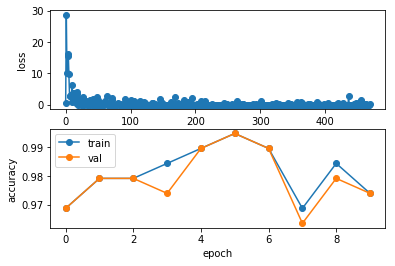

/home/Fengjiao/.local/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ThreeLayerConvWithBN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
################################## SCRIPT #####################################

##### intialize parameters of 3-layer ConvNet
#learning_rate = 1e-3  # 1e-3 gave max of 97.25% on val, 
#channel_1, channel_2, channel_3= 32, 16, 8
#
#model_1 = ThreeLayerConvWithBN(in_channel=3, channel_1=channel_1,
#                             channel_2=channel_2, num_classes=2)
## optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
#loss_history, val_acc_history, train_acc_history = \
#    train_model(model_1, optimizer, epochs=3, return_history=True)
#        
#check_accuracy(loader_test, model_1, training=False, print_out=True)
# 97.87% accuracy on test set
    
#### intialize parameters of 6 layer ConvNet
learning_rate = 1e-3  # 3e-4 gave max of almost 97% on val, 
channel_1, channel_2, channel_3, channel_4= 32, 16, 8, 4
model_2 =  ThreeLayerConvWithBN(in_channel=3, channel_1=channel_1,
                             channel_2=channel_2, num_classes=2)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
loss_history, val_acc_history, train_acc_history = \
    train_model(model_2, optimizer, epochs=10, return_history=True)
    
check_accuracy(loader_test, model_2, training=False, print_out=True)
## 99% accuracy on test set
    
plt.subplot(2,1,1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2,1,2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# save the model if its good!
torch.save(model_2, 'adam_3layer_conv_maxpool_3epochs_op_flow.pt')

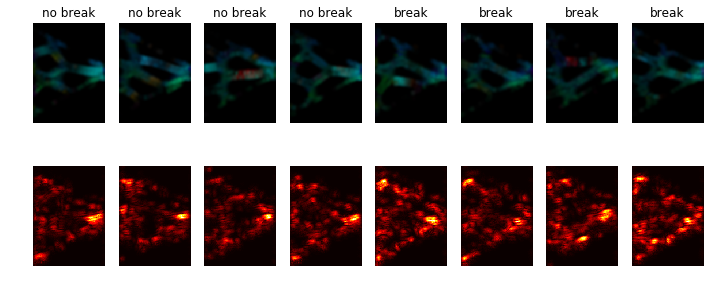

In [14]:
my_model = torch.load('adam_6layer_conv_maxpool_3epochs_op_flow.pt')

# display saliency maps
nobreak_locs = (loader_train.dataset.tensors[1] == 1).nonzero()[:,0]
break_locs = (loader_train.dataset.tensors[1] == 0).nonzero()[:,0]
nobreak_locs = np.random.permutation(np.array(nobreak_locs))
break_locs = np.random.permutation(np.array(break_locs))
n = 4
locs = np.concatenate((break_locs[0:n],nobreak_locs[0:n]))
X = loader_train.dataset.tensors[0][locs,:,:,:]
y = loader_train.dataset.tensors[1][locs]
show_saliency_maps(X, y, my_model)


Learning rate: 1e-05

TRAINING EPOCH:  0
iteration 0, loss = 0.6847
checking accuracy on validation set
got 176 / 384 correct (45.83)

iteration 3, loss = 0.7095
checking accuracy on validation set
got 187 / 384 correct (48.70)

iteration 6, loss = 0.6887
checking accuracy on validation set
got 220 / 384 correct (57.29)

iteration 9, loss = 0.6723
checking accuracy on validation set
got 279 / 384 correct (72.66)

iteration 12, loss = 0.6540
checking accuracy on validation set
got 313 / 384 correct (81.51)

iteration 15, loss = 0.6523
checking accuracy on validation set
got 315 / 384 correct (82.03)

iteration 18, loss = 0.6685
checking accuracy on validation set
got 308 / 384 correct (80.21)

iteration 21, loss = 0.6543
checking accuracy on validation set
got 306 / 384 correct (79.69)

iteration 24, loss = 0.6268
checking accuracy on validation set
got 310 / 384 correct (80.73)

iteration 27, loss = 0.6335
checking accuracy on validation set
got 303 / 384 correct (78.91)

iteration 30

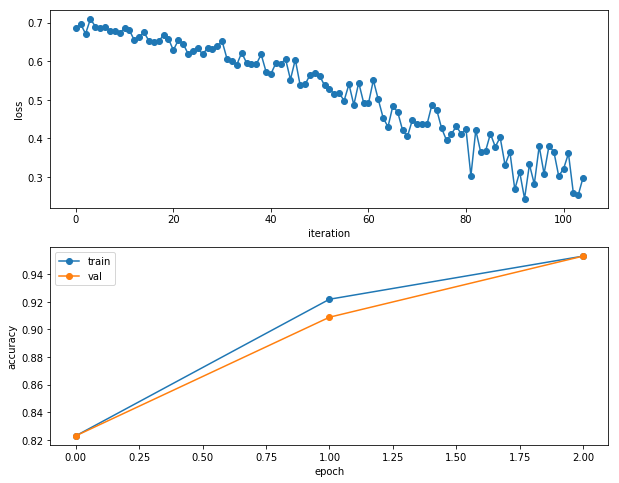

/home/Fengjiao/.local/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SixLayerConvWithPooling. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Learning rate: 3e-05

TRAINING EPOCH:  0
iteration 0, loss = 0.2580
checking accuracy on validation set
got 363 / 384 correct (94.53)

iteration 3, loss = 0.2968
checking accuracy on validation set
got 368 / 384 correct (95.83)

iteration 6, loss = 0.3377
checking accuracy on validation set
got 363 / 384 correct (94.53)

iteration 9, loss = 0.2445
checking accuracy on validation set
got 365 / 384 correct (95.05)

iteration 12, loss = 0.2089
checking accuracy on validation set
got 369 / 384 correct (96.09)

iteration 15, loss = 0.1710
checking accuracy on validation set
got 370 / 384 correct (96.35)

iteration 18, loss = 0.3180
checking accuracy on validation set
got 372 / 384 correct (96.88)

iteration 21, loss = 0.1336
checking accuracy on validation set
got 373 / 384 correct (97.14)

iteration 24, loss = 0.1463
checking accuracy on validation set
got 373 / 384 correct (97.14)

iteration 27, loss = 0.1475
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 30

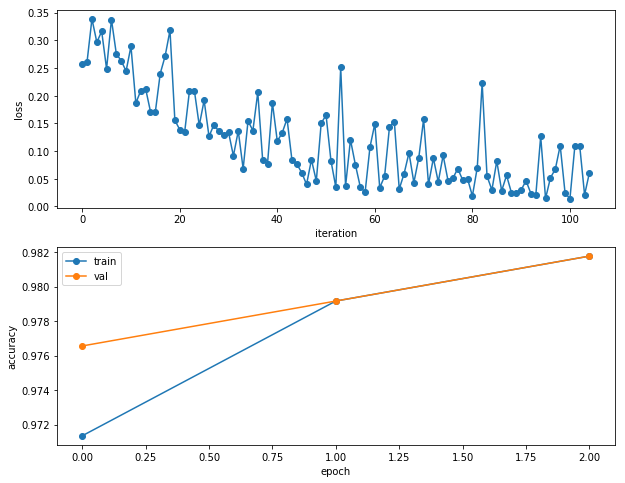


Learning rate: 5e-05

TRAINING EPOCH:  0
iteration 0, loss = 0.0282
checking accuracy on validation set
got 379 / 384 correct (98.70)

iteration 3, loss = 0.0187
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 6, loss = 0.0248
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 9, loss = 0.0369
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 12, loss = 0.0293
checking accuracy on validation set
got 376 / 384 correct (97.92)

iteration 15, loss = 0.0328
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 18, loss = 0.0371
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 21, loss = 0.0180
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 24, loss = 0.0046
checking accuracy on validation set
got 379 / 384 correct (98.70)

iteration 27, loss = 0.0159
checking accuracy on validation set
got 379 / 384 correct (98.70)

iteration 30

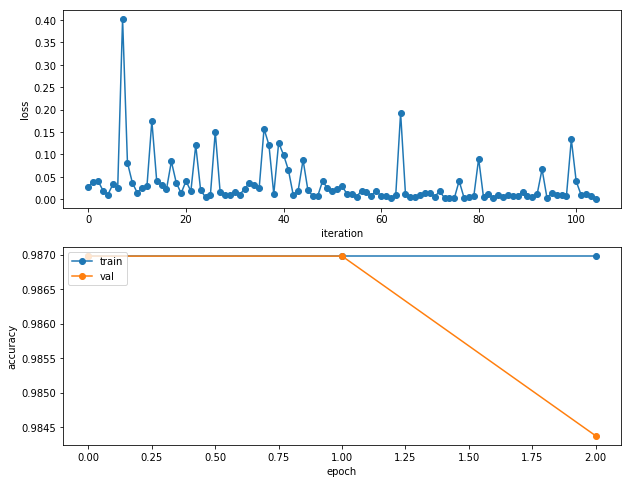


Learning rate: 7e-05

TRAINING EPOCH:  0
iteration 0, loss = 0.0059
checking accuracy on validation set
got 375 / 384 correct (97.66)

iteration 3, loss = 0.0129
checking accuracy on validation set
got 375 / 384 correct (97.66)

iteration 6, loss = 0.0131
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 9, loss = 0.0044
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 12, loss = 0.0177
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 15, loss = 0.0552
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 18, loss = 0.0028
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 21, loss = 0.0067
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 24, loss = 0.0205
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 27, loss = 0.0043
checking accuracy on validation set
got 377 / 384 correct (98.18)

iteration 30

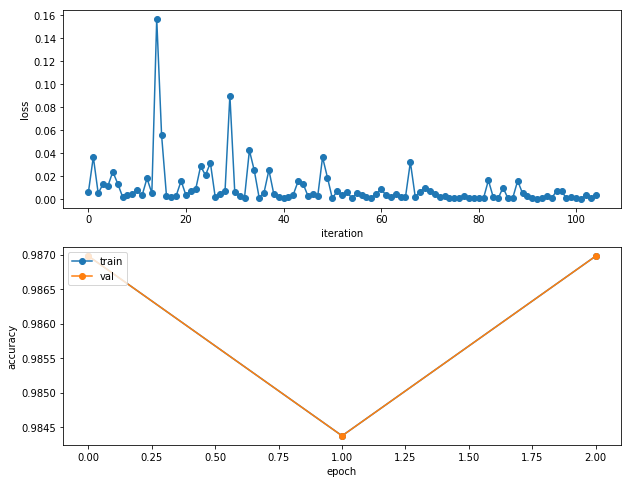


Learning rate: 9e-05

TRAINING EPOCH:  0
iteration 0, loss = 0.0008
checking accuracy on validation set
got 376 / 384 correct (97.92)

iteration 3, loss = 0.0213
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 6, loss = 0.0154
checking accuracy on validation set
got 376 / 384 correct (97.92)

iteration 9, loss = 0.0052
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 12, loss = 0.0107
checking accuracy on validation set
got 374 / 384 correct (97.40)

iteration 15, loss = 0.0009
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 18, loss = 0.0161
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 21, loss = 0.0031
checking accuracy on validation set
got 378 / 384 correct (98.44)

iteration 24, loss = 0.0114
checking accuracy on validation set
got 379 / 384 correct (98.70)

iteration 27, loss = 0.0002
checking accuracy on validation set
got 379 / 384 correct (98.70)

iteration 30

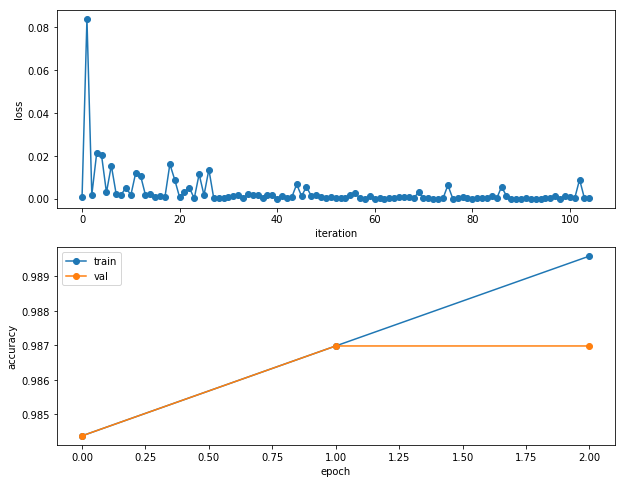

In [22]:
learning_rates = [1e-5, 3e-5, 5e-5, 7e-5, 9e-5]
channel_1, channel_2, channel_3, channel_4= 32, 16, 8, 4
model_2 =  SixLayerConvWithPooling(in_channel=3, channel_1=channel_1,
                             channel_2=channel_2, channel_3=channel_3,
                             channel_4=channel_4, num_classes=2)

for learning_rate in learning_rates:
    print('\nLearning rate:', learning_rate)
    optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
    loss_history, val_acc_history, train_acc_history = \
        train_model(model_2, optimizer, epochs=3, return_history=True)

    check_accuracy(loader_test, model_2, training=False, print_out=True)
    ## 99% accuracy on test set

    plt.subplot(2,1,1)
    plt.plot(loss_history, '-o')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.subplot(2,1,2)
    plt.plot(train_acc_history, '-o')
    plt.plot(val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    # save the model if its good!
#     model_name = 'adam_6layer_optflow_' + str(learning_rate) + '.pt'
#     torch.save(model_2, model_name)


Learning rate: 0.001

TRAINING EPOCH:  0
iteration 0, loss = 0.6885
checking accuracy on validation set
got 142 / 192 correct (73.96)

iteration 3, loss = 0.4785
checking accuracy on validation set
got 93 / 192 correct (48.44)

iteration 6, loss = 0.5534
checking accuracy on validation set
got 151 / 192 correct (78.65)

iteration 9, loss = 0.2749
checking accuracy on validation set
got 171 / 192 correct (89.06)

iteration 12, loss = 0.1441
checking accuracy on validation set
got 179 / 192 correct (93.23)

iteration 15, loss = 0.0684
checking accuracy on validation set
got 178 / 192 correct (92.71)

iteration 18, loss = 0.3849
checking accuracy on validation set
got 177 / 192 correct (92.19)

iteration 21, loss = 0.1404
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 24, loss = 0.0496
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 27, loss = 0.0706
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 30,

got 188 / 192 correct (97.92)

iteration 12, loss = 0.2253
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 15, loss = 0.0343
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 18, loss = 0.2803
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 21, loss = 0.0191
checking accuracy on validation set
got 191 / 192 correct (99.48)

iteration 24, loss = 0.0016
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 27, loss = 0.0066
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 30, loss = 0.0206
checking accuracy on validation set
got 192 / 192 correct (100.00)

iteration 33, loss = 0.1379
checking accuracy on validation set
got 192 / 192 correct (100.00)

iteration 36, loss = 0.0351
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 39, loss = 0.0309
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 42, los

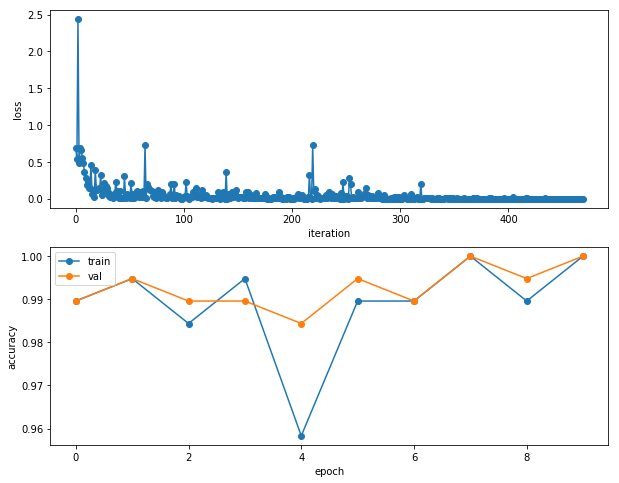

/home/Fengjiao/.local/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SixLayerConvWithPooling. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
learning_rates = [1e-3]
channel_1, channel_2, channel_3, channel_4= 32, 16, 8, 4
model_2 =  SixLayerConvWithPooling(in_channel=3, channel_1=channel_1,
                             channel_2=channel_2, channel_3=channel_3,
                             channel_4=channel_4, num_classes=2)

for learning_rate in learning_rates:
    print('\nLearning rate:', learning_rate)
    optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
    loss_history, val_acc_history, train_acc_history = \
        train_model(model_2, optimizer, epochs=10, return_history=True)

    check_accuracy(loader_test, model_2, training=False, print_out=True)
    ## 99% accuracy on test set

    plt.subplot(2,1,1)
    plt.plot(loss_history, '-o')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.subplot(2,1,2)
    plt.plot(train_acc_history, '-o')
    plt.plot(val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
# save the model if its good!
torch.save(model_2, 'adam_6layer_conv_maxpool_3epochs_op_flow.pt')


Learning rate: 0.001

TRAINING EPOCH:  0
iteration 0, loss = 0.6962
checking accuracy on validation set
got 102 / 192 correct (53.12)

iteration 3, loss = 0.6403
checking accuracy on validation set
got 171 / 192 correct (89.06)

iteration 6, loss = 0.4530
checking accuracy on validation set
got 133 / 192 correct (69.27)

iteration 9, loss = 0.2486
checking accuracy on validation set
got 159 / 192 correct (82.81)

iteration 12, loss = 0.1906
checking accuracy on validation set
got 180 / 192 correct (93.75)

iteration 15, loss = 0.3603
checking accuracy on validation set
got 183 / 192 correct (95.31)

iteration 18, loss = 0.2416
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 21, loss = 0.1539
checking accuracy on validation set
got 184 / 192 correct (95.83)

iteration 24, loss = 0.2486
checking accuracy on validation set
got 186 / 192 correct (96.88)

iteration 27, loss = 0.1461
checking accuracy on validation set
got 187 / 192 correct (97.40)

iteration 30

got 191 / 192 correct (99.48)

iteration 12, loss = 0.0001
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 15, loss = 0.0000
checking accuracy on validation set
got 189 / 192 correct (98.44)

iteration 18, loss = 0.0031
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 21, loss = 0.0000
checking accuracy on validation set
got 188 / 192 correct (97.92)

iteration 24, loss = 0.0108
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 27, loss = 0.0001
checking accuracy on validation set
got 191 / 192 correct (99.48)

iteration 30, loss = 0.0002
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 33, loss = 0.0000
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 36, loss = 0.0012
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 39, loss = 0.0001
checking accuracy on validation set
got 190 / 192 correct (98.96)

iteration 42, loss 

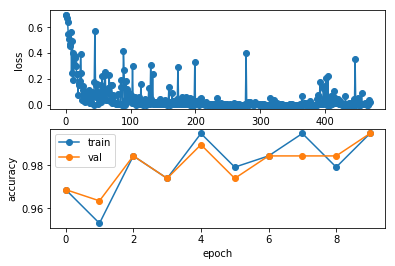

In [45]:
learning_rates = [1e-3]
channel_1, channel_2, channel_3, channel_4, channel_5, channel_6= 32, 16, 8, 4, 4, 4
model_2 =  NineLayerConvWithPooling(in_channel=3, channel_1=channel_1,
                             channel_2=channel_2, channel_3=channel_3,
                             channel_4=channel_4, channel_5=channel_5,
                             channel_6=channel_6, num_classes=2)

for learning_rate in learning_rates:
    print('\nLearning rate:', learning_rate)
    optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
    loss_history, val_acc_history, train_acc_history = \
        train_model(model_2, optimizer, epochs=10, return_history=True)

    check_accuracy(loader_test, model_2, training=False, print_out=True)
    ## 99% accuracy on test set

    plt.subplot(2,1,1)
    plt.plot(loss_history, '-o')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.subplot(2,1,2)
    plt.plot(train_acc_history, '-o')
    plt.plot(val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
    # save the model if its good!
    model_name = 'adam_9layer_optflow.pt'